# Data augmentation

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_09 import *

## PIL transforms

In [ ]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

In [ ]:
from nvidia.dali.pipeline import Pipeline

In [ ]:
import nvidia.dali.ops as ops
import nvidia.dali.types as types

In [ ]:
bs=8

In [ ]:
class SimplePipeline(Pipeline):
    def __init__(self, batch_size=8, num_threads=8, device_id=0):
        super(SimplePipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.input = ops.FileReader(file_root = path/'train')
        # self.input = ops.FileReader(file_root = image_dir, file_list = image_dir + '/file_list.txt')
        self.resize = ops.Resize(device = "cpu", resize_x=128, resize_y=128, image_type = types.RGB,
            interp_type = types.INTERP_LINEAR)
        self.decode = ops.HostDecoder(output_type = types.RGB)

    def define_graph(self):
        jpegs, labels = self.input(name='r')
        images = self.decode(jpegs)
        images = self.resize(images)
        return (images, labels)

In [ ]:
pipe = SimplePipeline()
pipe.build()

In [ ]:
pipe_out = pipe.run()
print(pipe_out)

[<nvidia.dali.backend_impl.TensorListCPU object at 0x7f9ddc518500>, <nvidia.dali.backend_impl.TensorListCPU object at 0x7f9ddc518260>]


In [ ]:
images, labels = pipe_out
images.is_dense_tensor(), labels.is_dense_tensor()

(True, True)

In [ ]:
t = images.as_tensor()

In [ ]:
from nvidia.dali.plugin.pytorch import DALIGenericIterator,DALIClassificationIterator,feed_ndarray

In [ ]:
it = DALIGenericIterator(pipe, ['data','label'], pipe.epoch_size('r'))

In [ ]:
it = DALIClassificationIterator(pipe, pipe.epoch_size('r'))

In [ ]:
its = iter(it)

In [ ]:
t = next(it)[0]

In [ ]:
t['label'].cuda().long().type()

'torch.cuda.LongTensor'

In [ ]:
t['data'].type()

'torch.ByteTensor'

In [ ]:
import numpy as np

In [ ]:
labels_tensor = labels.as_tensor()

In [ ]:
labels_tensor.shape()

[8, 1]

In [ ]:
np.array(labels_tensor)

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [ ]:
import matplotlib.gridspec as gridspec

In [ ]:
def show_images(image_batch):
    columns = 4
    rows = len(image_batch) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))

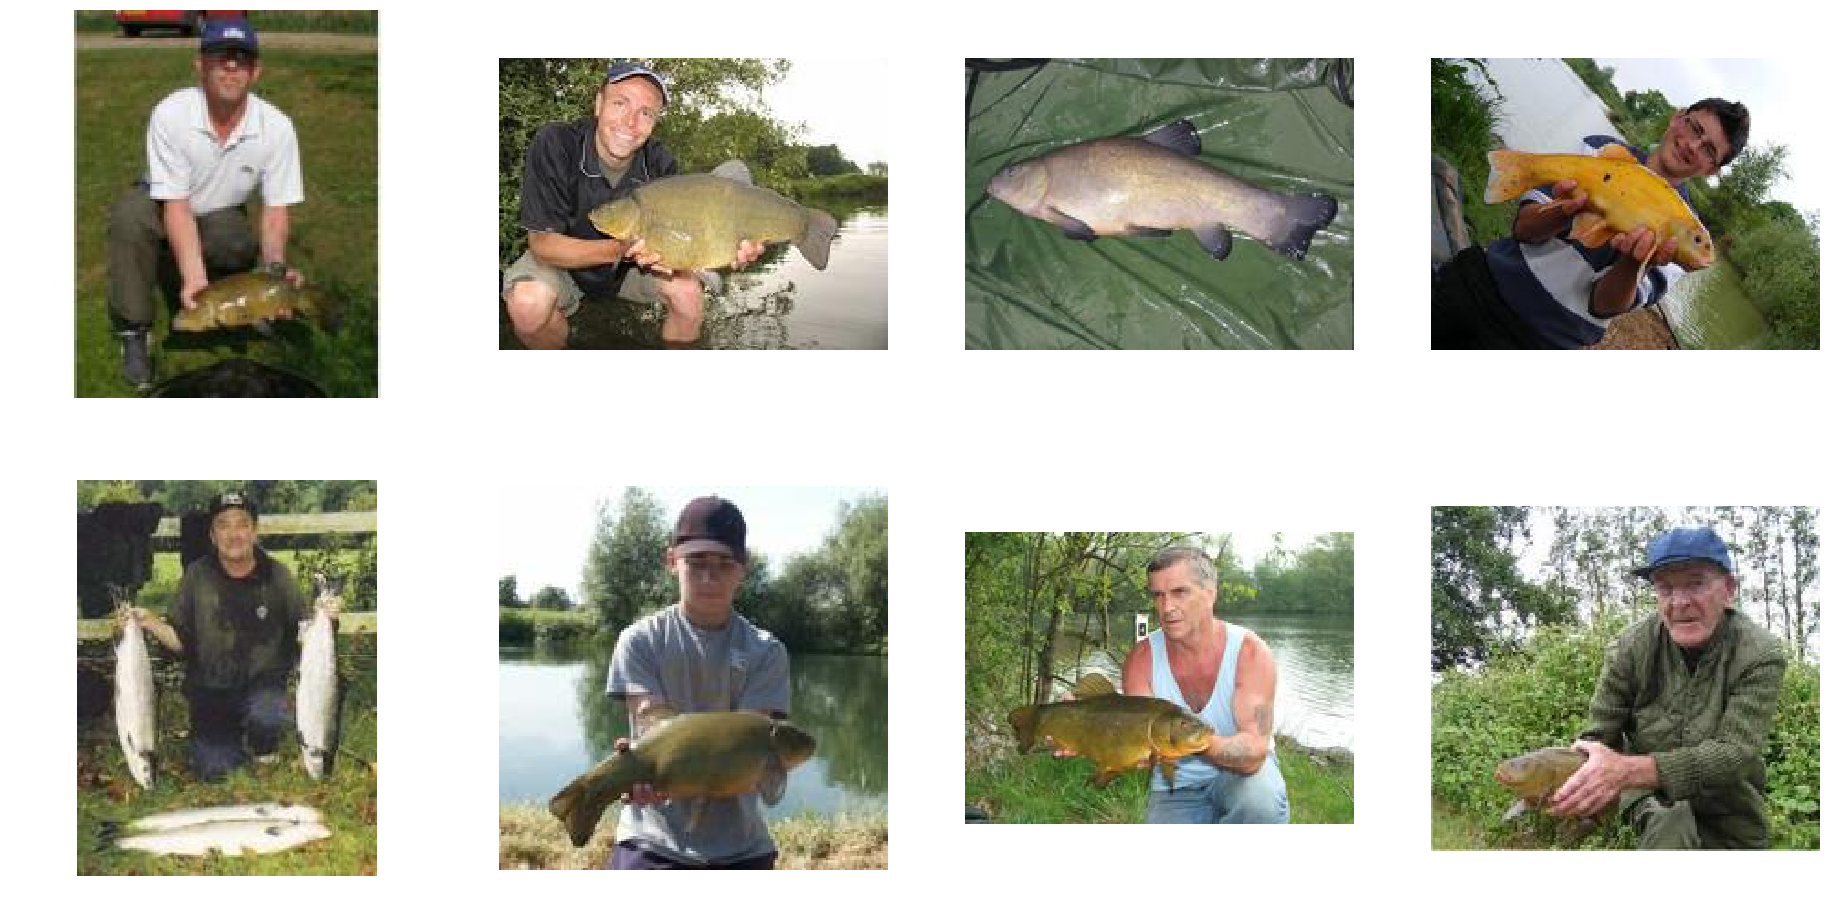

In [ ]:
show_images(images)

In [ ]:
def get_il(tfms): return ImageList.from_files(path, tfms=tfms)

In [ ]:
il = get_il(tfms)

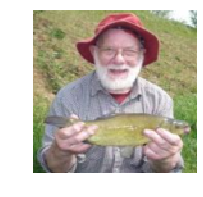

In [ ]:
show_image(il[0])

In [ ]:
img = PIL.Image.open(il.items[0])

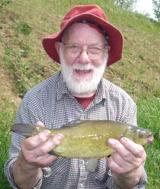

In [ ]:
img

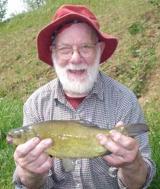

In [ ]:
img.transpose(PIL.Image.FLIP_LEFT_RIGHT)

In [ ]:
#export
from random import random

def show_aug(gen, r=1, c=4, figsize=None):
    if figsize is None: figsize=(c*3,r*3)
    fig,axes = plt.subplots(r,c, figsize=figsize)
    for ax in axes.flat:
        ax.imshow(gen())
        ax.axis('off')

In [ ]:
def pil_random_flip(x): return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random()<0.5 else x

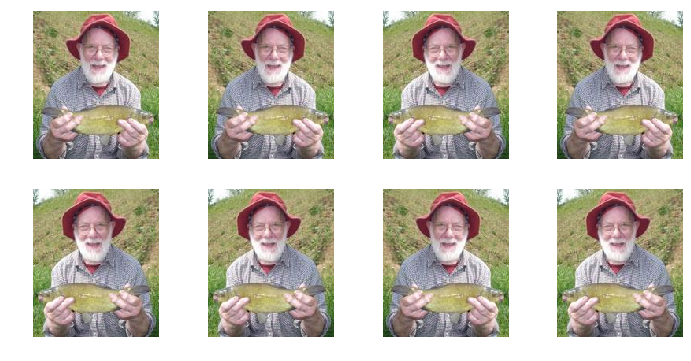

In [ ]:
show_aug(partial(pil_random_flip, img), r=2)

In [ ]:
il1 = get_il(tfms)
il1.items = [il1.items[0]]*8
dl = DataLoader(il1, 8)

In [ ]:
x = next(iter(dl))

In [ ]:
#export
def show_image(im, ax=None, figsize=(3,3)):
    if ax is None: _,ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    ax.imshow(im.permute(1,2,0))

def show_batch(x, c=4, figsize=None):
    n = len(x)
    r = int(math.ceil(n/c))
    if figsize is None: figsize=(c*3,r*3)
    fig,axes = plt.subplots(r,c, figsize=figsize)
    for xi,ax in zip(x,axes.flat): show_image(xi, ax)

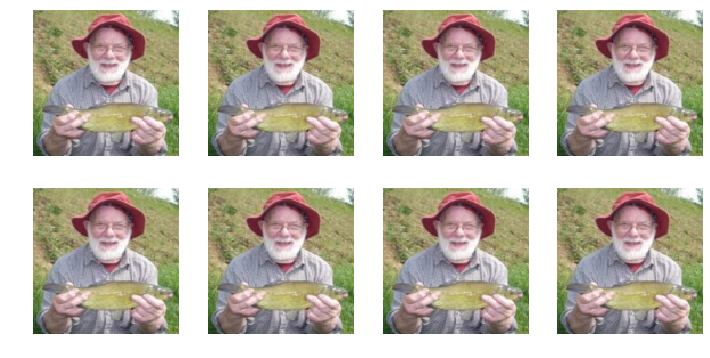

In [ ]:
show_batch(x)

In [ ]:
il1.tfms.append(pil_random_flip)

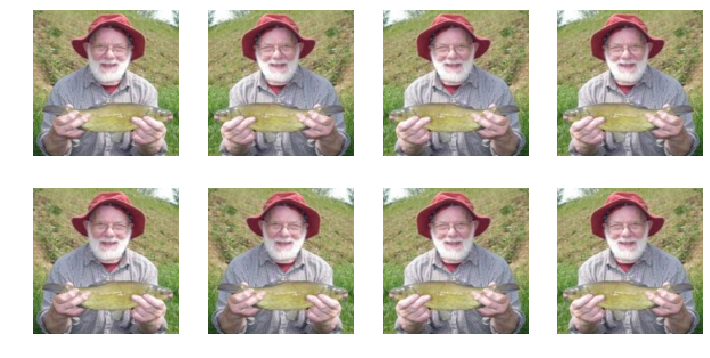

In [ ]:
x = next(iter(dl))
show_batch(x)

In [ ]:
class PilRandomFlip(Transform):
    _order=11
    def __init__(self, p=0.5): self.p=p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random()<self.p else x

In [ ]:
class PilTransform(Transform): _order=11

class PilRandomFlip(PilTransform):
    def __init__(self, p=0.5): self.p=p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random()<self.p else x

In [ ]:
del(il1.tfms[-1])
il1.tfms.append(PilRandomFlip(0.8))

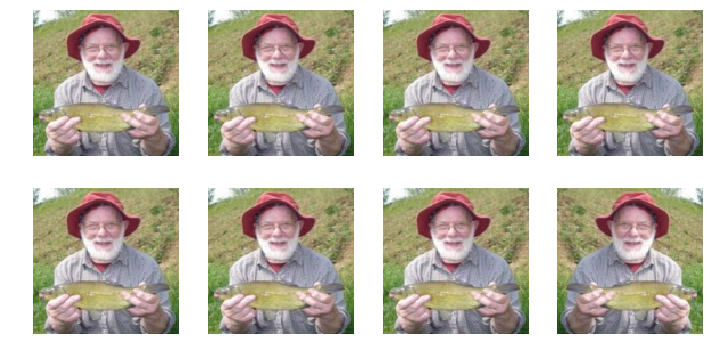

In [ ]:
x = next(iter(dl))
show_batch(x)

### Model

In [ ]:
nfs = [32,64,128,256,512]

In [ ]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [ ]:
data = DataBunch(train_dl, valid_dl, 3, 10)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [ ]:
run.fit(1, learn)

train: [1.7537384151543354, tensor(0.3995, device='cuda:0')]
valid: [1.71223388671875, tensor(0.4380, device='cuda:0')]


## Export

In [ ]:
!./notebook2script.py 09_optimizers.ipynb

Converted 09_optimizers.ipynb to nb_09.py
